In [1]:
code_path = '/Users/amandabuch/Documents/clusterCCA/PCMF/'

loading_dir_fullpath=code_path+'results_r01/'


In [2]:
####
import os
os.getcwd()
import numpy as np
import sys
import multiprocessing  

os.chdir(code_path)

import pandas as pd

import mosek
import cvxpy as cp
import time
from itertools import combinations
from admm_utils import prox as cprox
from pcmf import pcmf_full, pcmf_approx_uV
from sklearn.preprocessing import StandardScaler

import argparse

import sys
from datetime import datetime as dt
import pandas as pd
from shutil import copyfile

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import normalized_mutual_info_score
from scipy.stats import multivariate_normal
from collections import OrderedDict
np.random.seed(1234)

from p3ca import admm_CCA_new, path_plot
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')
    


In [3]:
from matplotlib import pyplot as plt
def path_plot2(coefficient_arr, penalty_list, plot_range=[0,-1], cut_vars=False, 
              first_vars_only=False, var_sel=1, true_clusters=None,figsize=(20,10), xticks=None):
    import numpy as np
    import matplotlib
    from matplotlib import pyplot as plt
    import seaborn as sns; sns.set()

    # Crop x axis (e.g, to remove 'burn-in' period at beginning)                                                         
    coefficient_arr = coefficient_arr[plot_range[0]:plot_range[1],:,:]
    penalty_list = penalty_list[plot_range[0]:plot_range[1]]
    if cut_vars is True:
        coefficient_arr = coefficient_arr[:,:,[1,2,coefficient_arr.shape[2]-1]]

    if first_vars_only is True:
        coefficient_arr = coefficient_arr[:,:,[var_sel]]

    # Colormap                                                                                                           
    cmap = matplotlib.cm.get_cmap('tab20b')

    #cm.get_cmap('viridis', coefficient_arr.shape[2])
    if true_clusters is not None:
        colors = cmap(np.linspace(0.0,1.0,len(np.unique(true_clusters)) ))
    else:
        colors = cmap(np.linspace(0.0,1.0,coefficient_arr.shape[1]))
    
    # Define x-axis range                                                                                                
    penalty_range = range(len(penalty_list))

    # Make figure
    fig, ax = plt.subplots(1,1, figsize=figsize)

    for i in range(coefficient_arr.shape[2]):
        x = np.round(np.array(penalty_list),8)[penalty_range]
        y = coefficient_arr[penalty_range,:,i]
        if true_clusters is not None:
            # Make different line types for different clusters
            linetypes = ['dotted']*len(true_clusters)
            color_list = [colors[i]]*len(true_clusters)
            for j, tc in enumerate(true_clusters):
                if tc == 1:
                    linetypes[j] = 'solid'
                    color_list[j] = colors[tc]
                elif tc == 2:
                    linetypes[j] = 'dashed'
                    color_list[j] = colors[tc]
                elif tc == 0:
                    linetypes[j] = 'dotted'
                    color_list[j] = colors[tc]
                else:
                    linetypes[j] = 'dashdot'
                    color_list[j] = colors[tc]

            # Plot the lines and set linestyle
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
            for l, line in enumerate(ax.get_lines()):
                line.set_linestyle(linetypes[l])
                line.set_color(color_list[l])
        else:
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
        # Set plot ticks and labels
        ax.set_facecolor('white')
        ax.set_xticks(range(x.shape[0]), minor=False);
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        x = [str(xx)[0:9] for xx in x]
        ax.set_xticklabels(x) #,fontsize=24)
        evens = np.arange(0,len(ax.xaxis.get_ticklabels())+1,2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False) 
    ax.tick_params(axis='y') #, labelsize=24)
    plt.xlabel(r'$\lambda$',fontsize=16)
    plt.ylabel('Coefficients',fontsize=16)
    sns.despine()
    

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI_score, adjusted_rand_score as ARI_score, rand_score as rand_score
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score, mean_squared_error # cohen_kappa_score, hinge_loss, coverage_error, consensus_score

def fit_spectral(X, true_clusters, n_clusters):
    '''Spectral clustering'''
    from sklearn.cluster import SpectralClustering
    #
    data_in = X
    #
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, random_state=20, affinity="nearest_neighbors").fit(data_in)
    labels = spectral_clustering.labels_
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc


from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment as linear_assignment
def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord

def calculate_scores(pred_clusters, true_clusters):
    """
    Calculate cluster accuracy scores and requires true clusters
    Calls cluster_along_path on each index i along penalties in path
    Params:
        true_clusters
        path_length
    Returns:
        path_clusters = list of clusterings at each penalty on path
        nmi_score = np-array of normalized mutual information score for each penalty
        adj_rand_score = np-array of adjusted rand score for each penalty
        rand_score = np-array of rand score for each penalty
        mse_score = np-array of mean squared error score for each penalty
    """
    nmi_score = NMI_score(true_clusters, pred_clusters, average_method='arithmetic')
    adj_rand_score = ARI_score(true_clusters, pred_clusters)
    ri_score = rand_score(true_clusters, pred_clusters)
    mse_score = mean_squared_error(true_clusters, pred_clusters)
    #
    return nmi_score, adj_rand_score, ri_score, mse_score

from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment as linear_assignment
def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord


def centroid_matrix(X,labels):
    '''
    Given a matrix X and labels clustering each of it's rows, return a matrix 
    where each row has been replaced by it's nearest centroid.
    '''
    centroid_dict = dict()
    X_out = np.zeros_like(X)
    keys, counts = np.unique(labels, return_counts=True)
    for k in keys:
        centroid_dict[k] = list() # np.zeros(X.shape[1])
    for i,l in enumerate(labels):
        centroid_dict[l].append(X[i,:])
    for j,k in enumerate(keys):
        centroid_dict[k] = np.mean(np.asarray(centroid_dict[k]), axis=0)
    for i,l in enumerate(labels):
        X_out[i,:] = centroid_dict[l]
    return X_out

def centroid_matrix_mixture(X,proba,means):
    '''
    Given a matrix X and labels clustering each of it's rows, return a matrix 
    where each row has been replaced by it's nearest centroid.
    '''
    centroid_dict = dict()
    X_out = np.zeros_like(X)
    for i in range(X_out.shape[0]):
        X_out[i,:] = np.dot(proba[i],means)
    return X_out

########### Model Selection functions ############
def cluster_fit(Xhat, num_clusters=2, gamma=2.0,  method='spectral'):
    # Cluster on the rows of Xhat with k=n_clust_previous
    if method == 'spectral':
        # clustering = SpectralClustering(n_clusters = num_clusters, gamma=gamma, \
                                        # assign_labels='discretize',affinity='rbf')
        clustering = SpectralClustering(n_clusters=num_clusters, random_state=0, gamma=gamma).fit(Xhat)
    elif method == 'kmeans':
        clustering = KMeans(n_clusters=num_clusters, random_state=0)
    elif method == 'gmm':
        clustering = GaussianMixture(n_components=num_clusters, warm_start=True)
    else:
        return ValueError('Selected clustering method not yet implemented.')
    clustering.fit(Xhat)
    #
    return clustering.labels_


def fit_pcmf(X, true_clusters, n_clusters, gauss_coef, c_method='spectral'):
    '''PCMF spectral clustering'''
    from sklearn.cluster import SpectralClustering
    #
    data_in = X
    #
    labels = cluster_fit(X, num_clusters=n_clusters, gamma=gauss_coef, method=c_method)
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

from sklearn.cluster import SpectralClustering
def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord

In [25]:
# results = np.load(loading_dir_fullpath+'p3CA_tumors5000genesAllMIRNA_run_gausscoef2.0_neighbors15_rho1.0_penaltyLength60.npz')
# results = np.load(loading_dir_fullpath+'P3CA_tumors5000genesAllMIRNA_run_gausscoef2.0_neighbors15_rho1.0_penaltyLength260.npz')
# results = np.load(loading_dir_fullpath+'P3CA_tumorsAllgeneMIRNA_run_gausscoef2.0_neighbors15_rho1.0_penaltyLength510.npz')
# results = np.load(loading_dir_fullpath+'P3CA_tumors5000genesAllMIRNA_run_gausscoef1.0_neighbors15_rho2.0_penaltyLength30.npz')
# results = np.load(loading_dir_fullpath+'P3CA_tumors1000genesAllMIRNA_run_gausscoef2.0_neighbors15_rho1.0_penaltyLength60.npz')

results = np.load(loading_dir_fullpath+'P3CA_tumorsAllgenesAllMIRNA_run_gausscoef1.0_neighbors15_rho2.0_penaltyLength30.npz')



true_clusters=results['true_clusters']
U_list=results['U_list']
V_list=results['V_list']
penalty_list=results['penalty_list']
rho=results['rho']
gauss_coef=results['gauss_coef']
neighbors=results['neighbors']
acc_list=results['acc_list']
ari_list=results['ari_list']
nmi_list=results['nmi_list']
['Best Penalty IDX:',np.argmax(np.array(ari_list)), 'ACC:',np.max(np.array(acc_list)), 'ARI:',np.max(np.array(ari_list)), 'NMI:',np.max(np.array(nmi_list))]

print(rho, gauss_coef, neighbors)



2.0 1.0 15


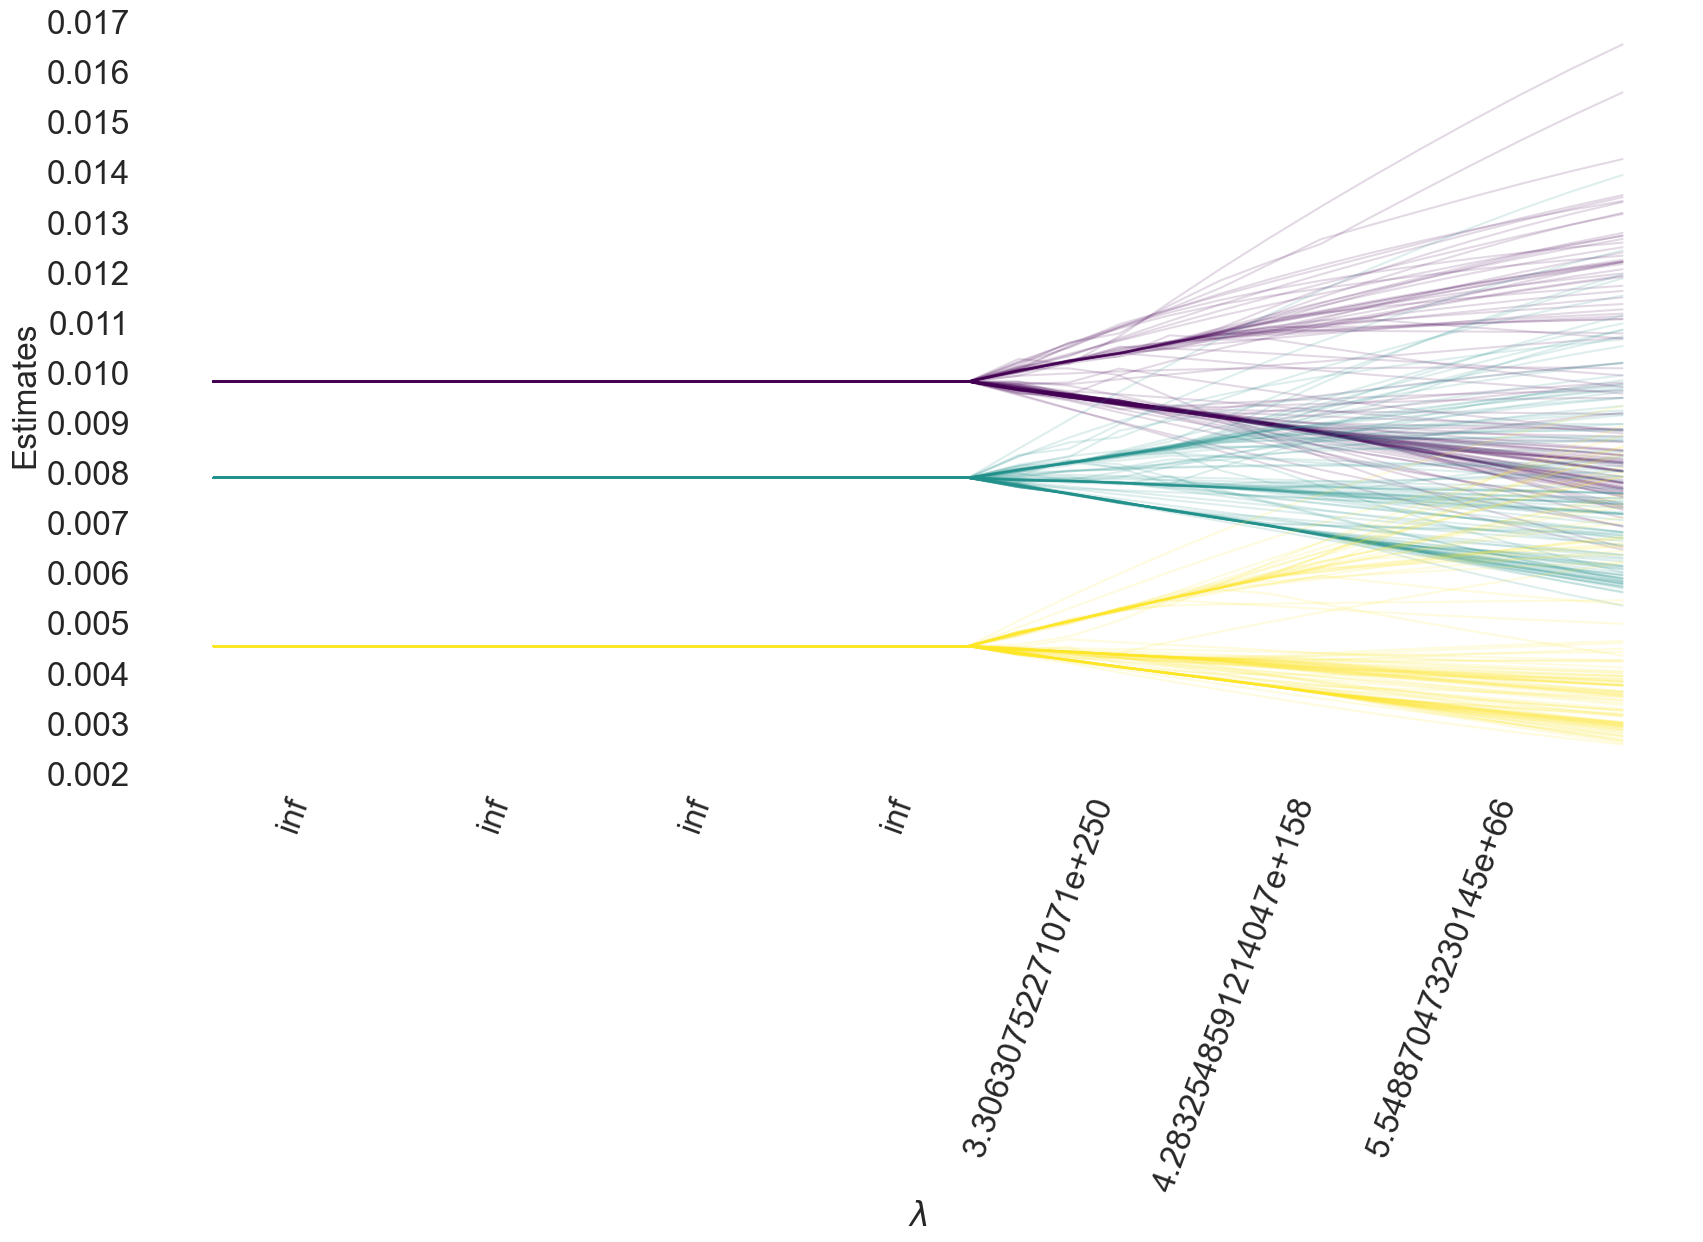

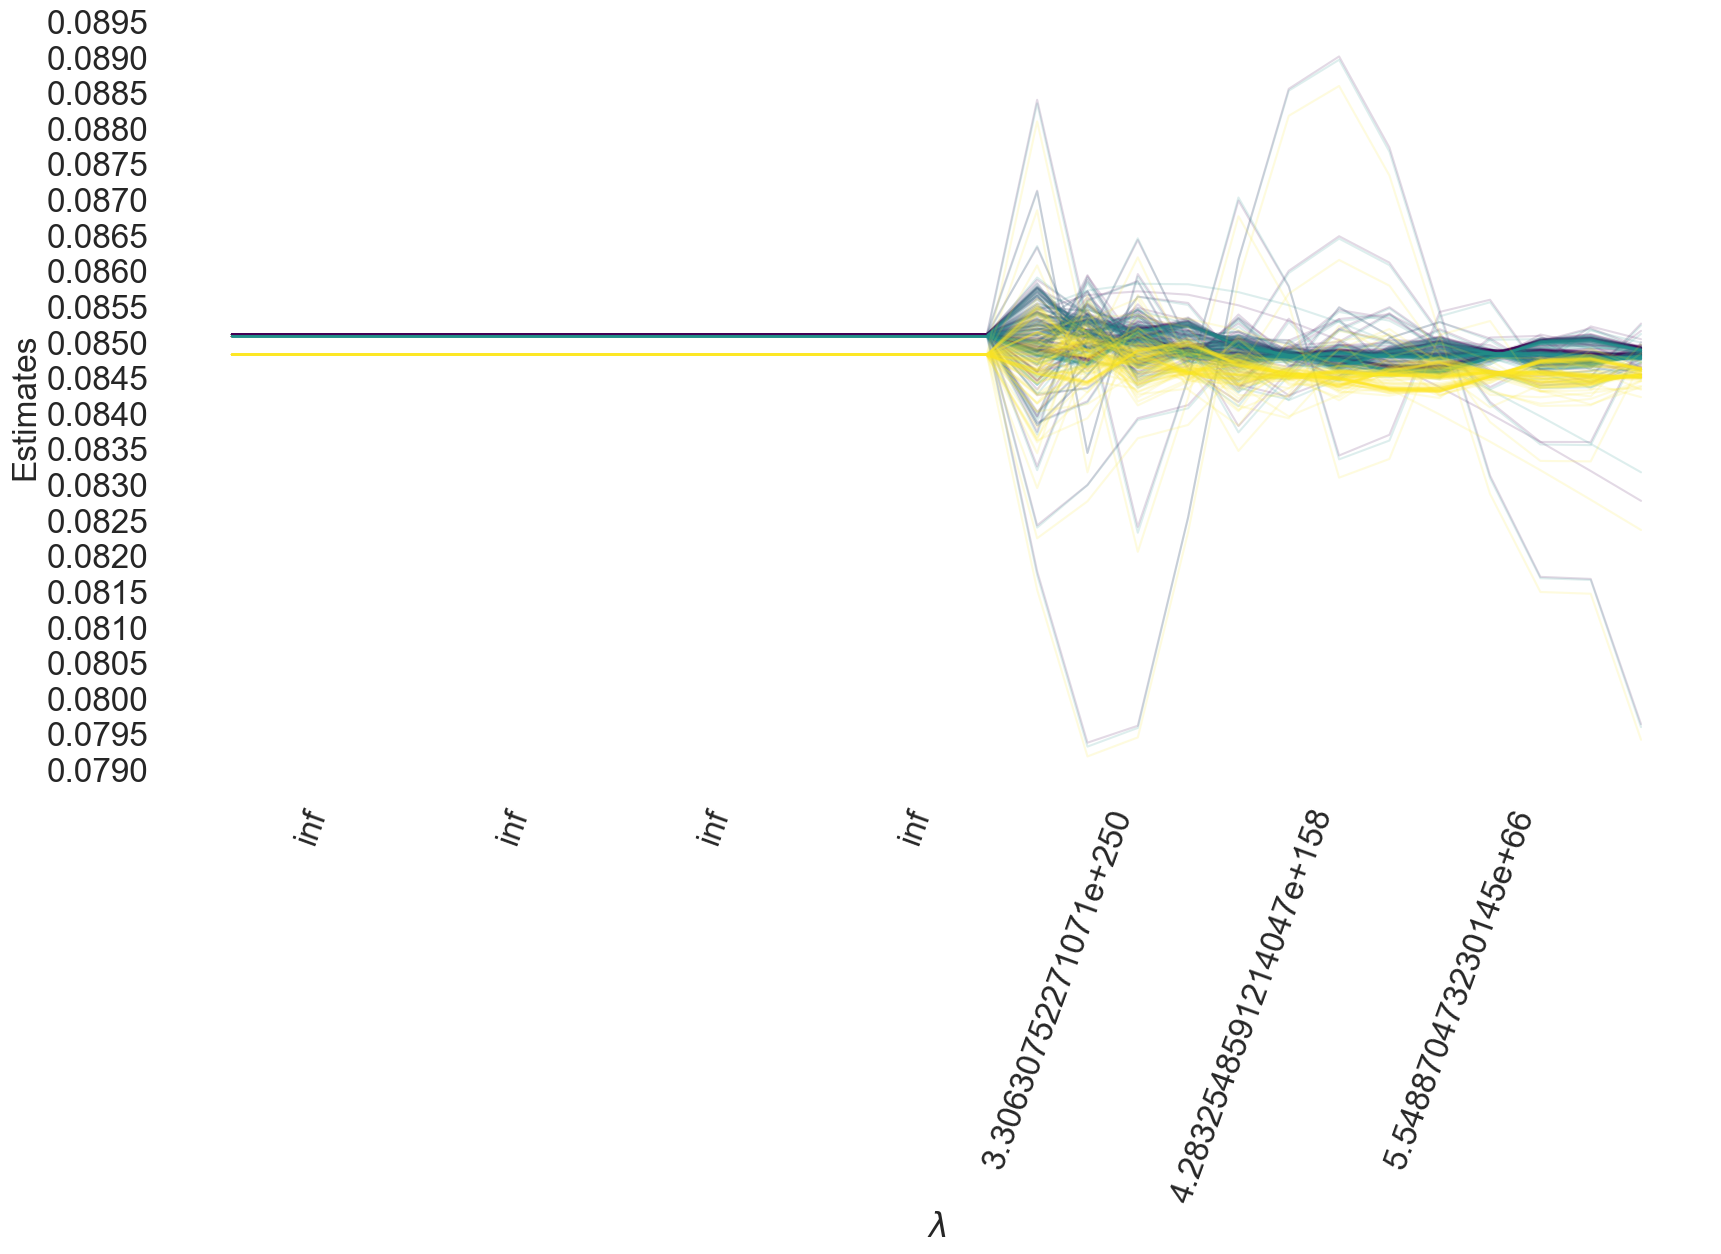

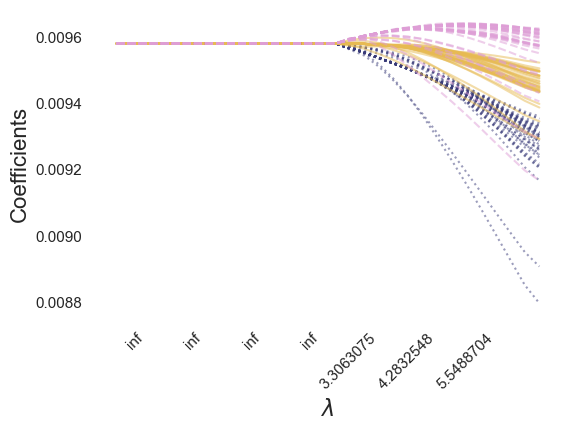

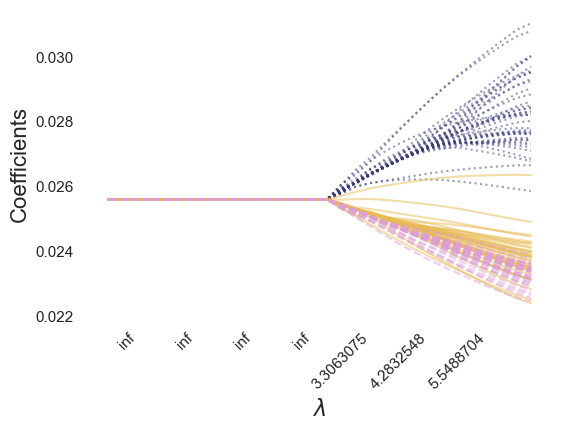

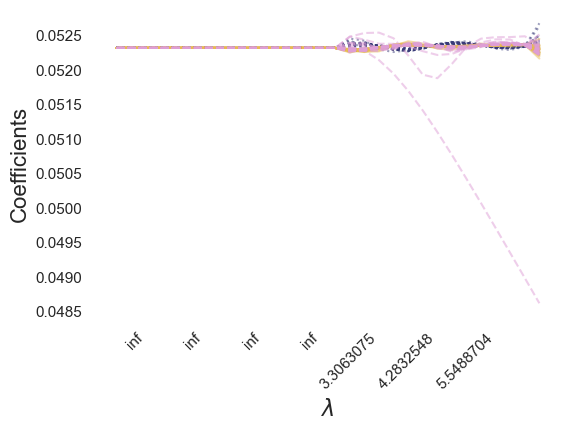

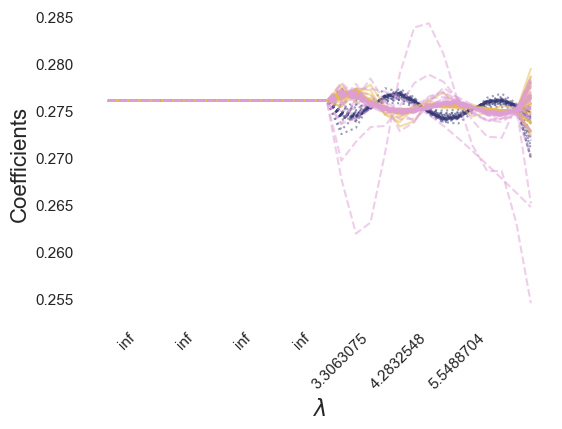

In [26]:
path_plot(np.asarray(U_list)[:,:,0:3], penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)
ax = plt.gca()
ax.set_facecolor('white')

path_plot(np.asarray(V_list)[:,:,0:3], penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)
ax = plt.gca()
ax.set_facecolor('white')

path_plot2(np.mean(np.asarray(U_list),axis=2)[:,:,np.newaxis], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot2(np.asarray(U_list)[:,:,-1:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)


path_plot2(np.mean(np.asarray(V_list),axis=2)[:,:,np.newaxis], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)


path_plot2(np.asarray(V_list)[:,:,-1:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)




In [27]:
# ari_list=[]
# nmi_list=[]
# acc_list=[]
# for p in range(len(penalty_list)):
#     labels, ari, nmi, acc = fit_spectral(np.hstack((np.array(U_list)[p,:,:],np.array(V_list)[p,:,:])), pd.factorize(true_clusters)[0], len(np.unique(true_clusters)))
#     acc_list.append(acc)
#     ari_list.append(ari)
#     nmi_list.append(nmi)

# ['Best Penalty IDX:',np.argmax(np.array(ari_list)), 'ACC:',np.max(np.array(acc_list)), 'ARI:',np.max(np.array(ari_list)), 'NMI:',np.max(np.array(nmi_list))]


Best IDX 29 ACC: 1.0 ARI: 1.0 NMI: 1.0


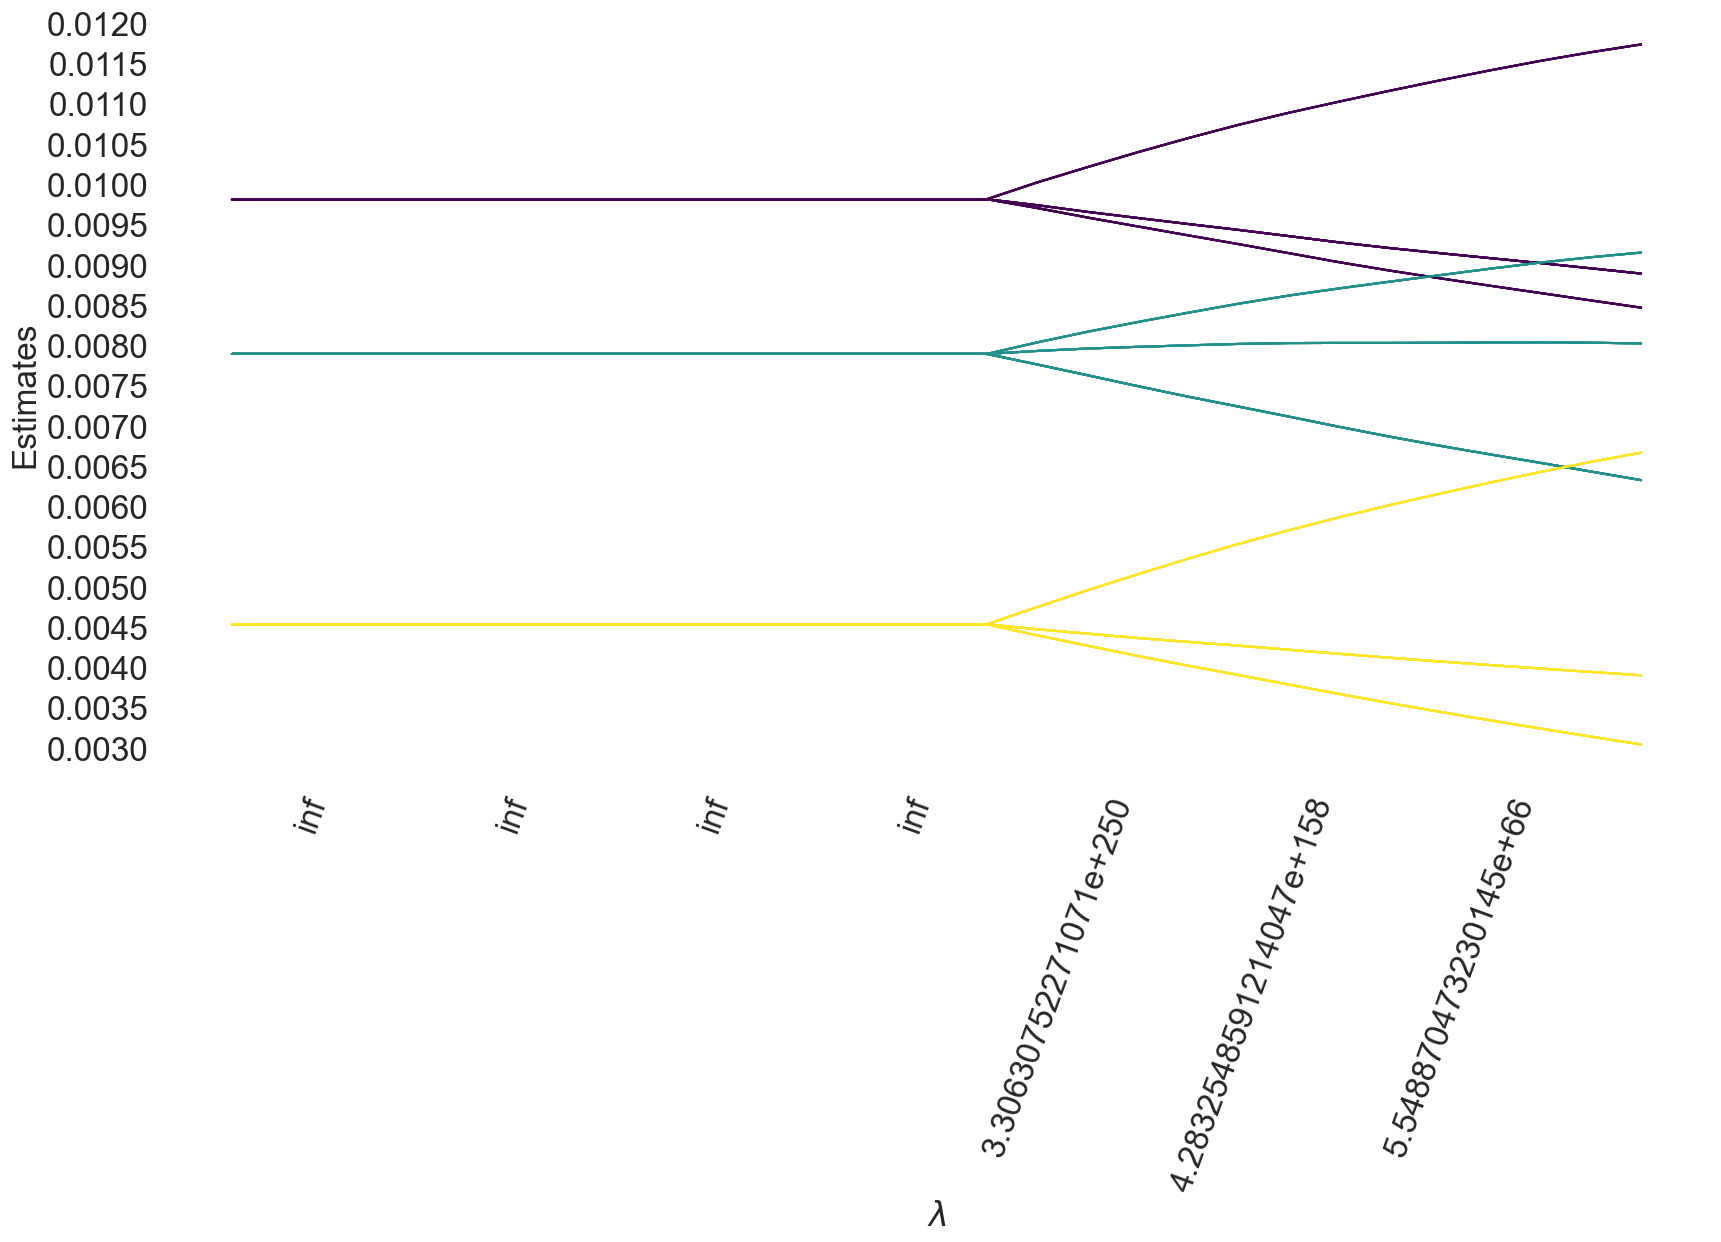

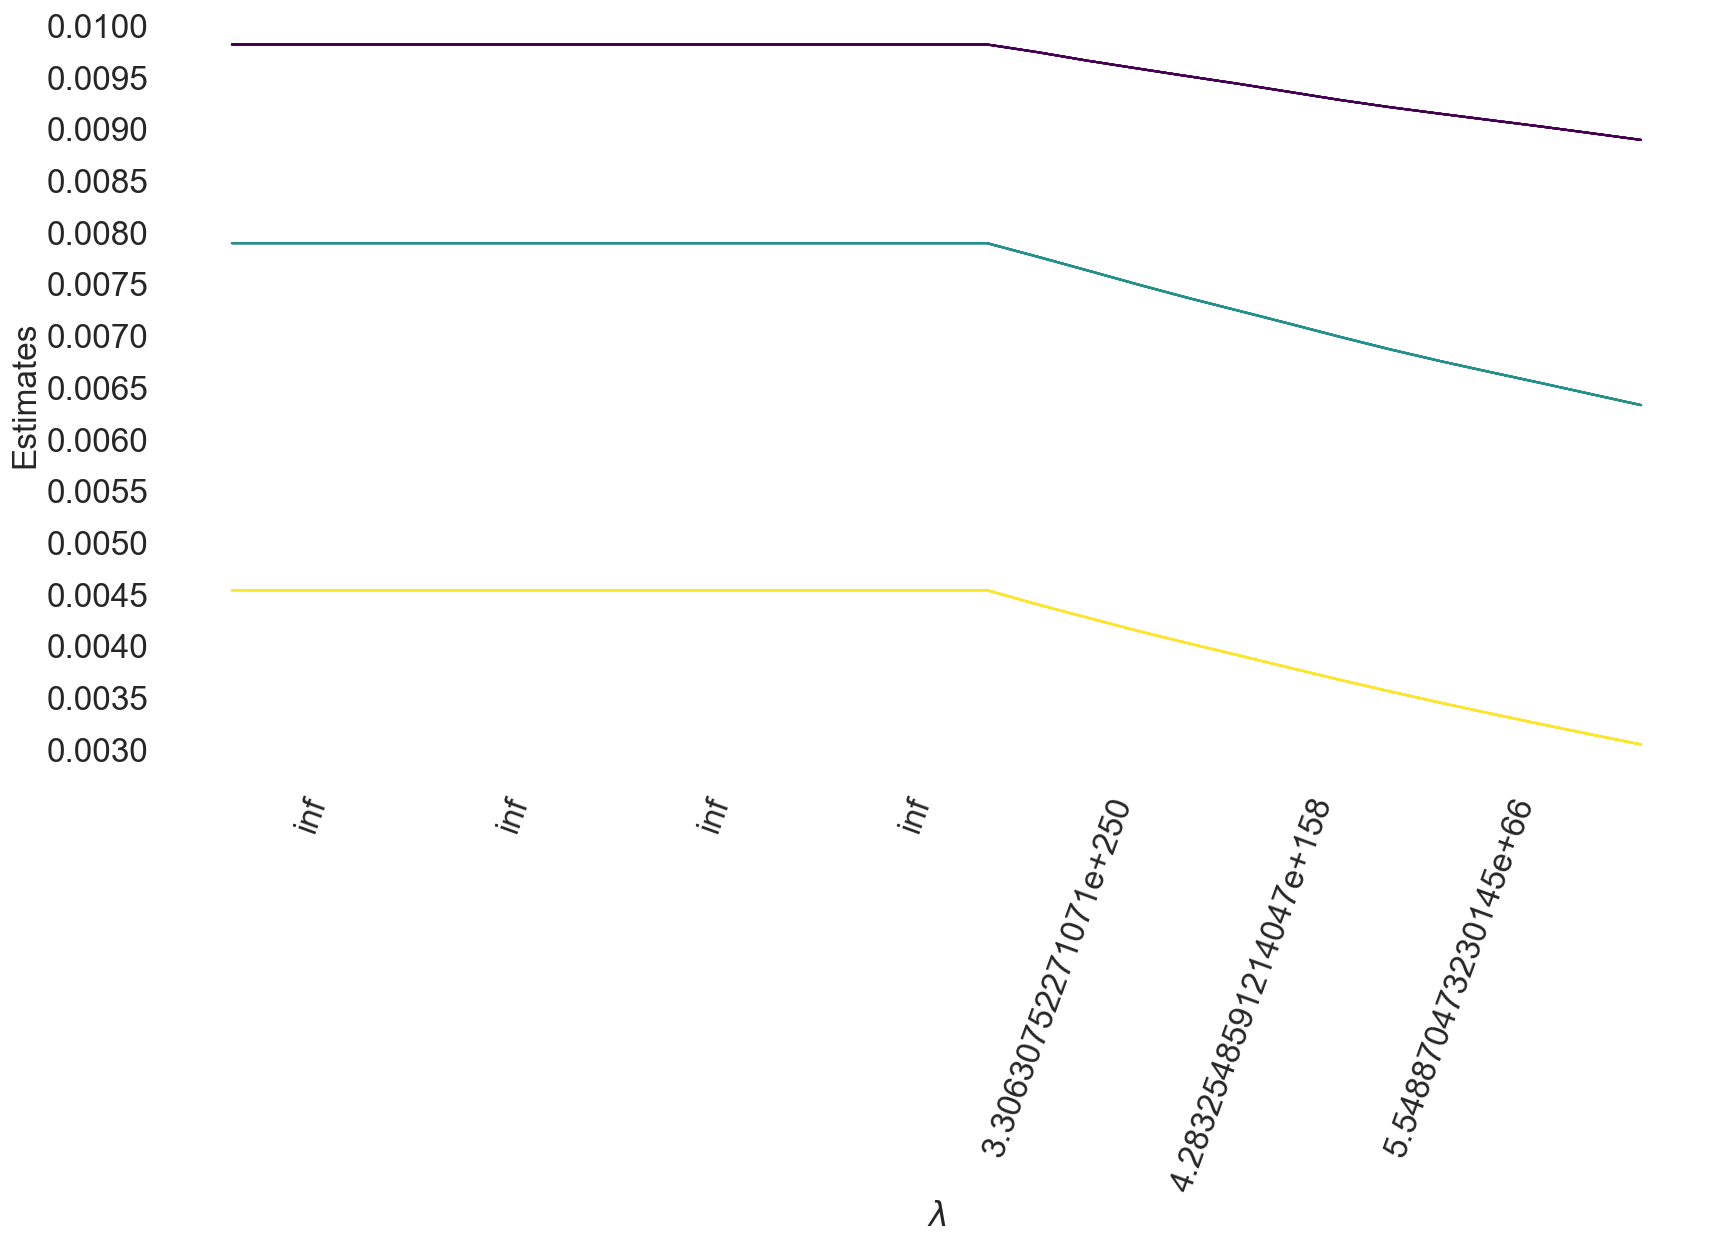

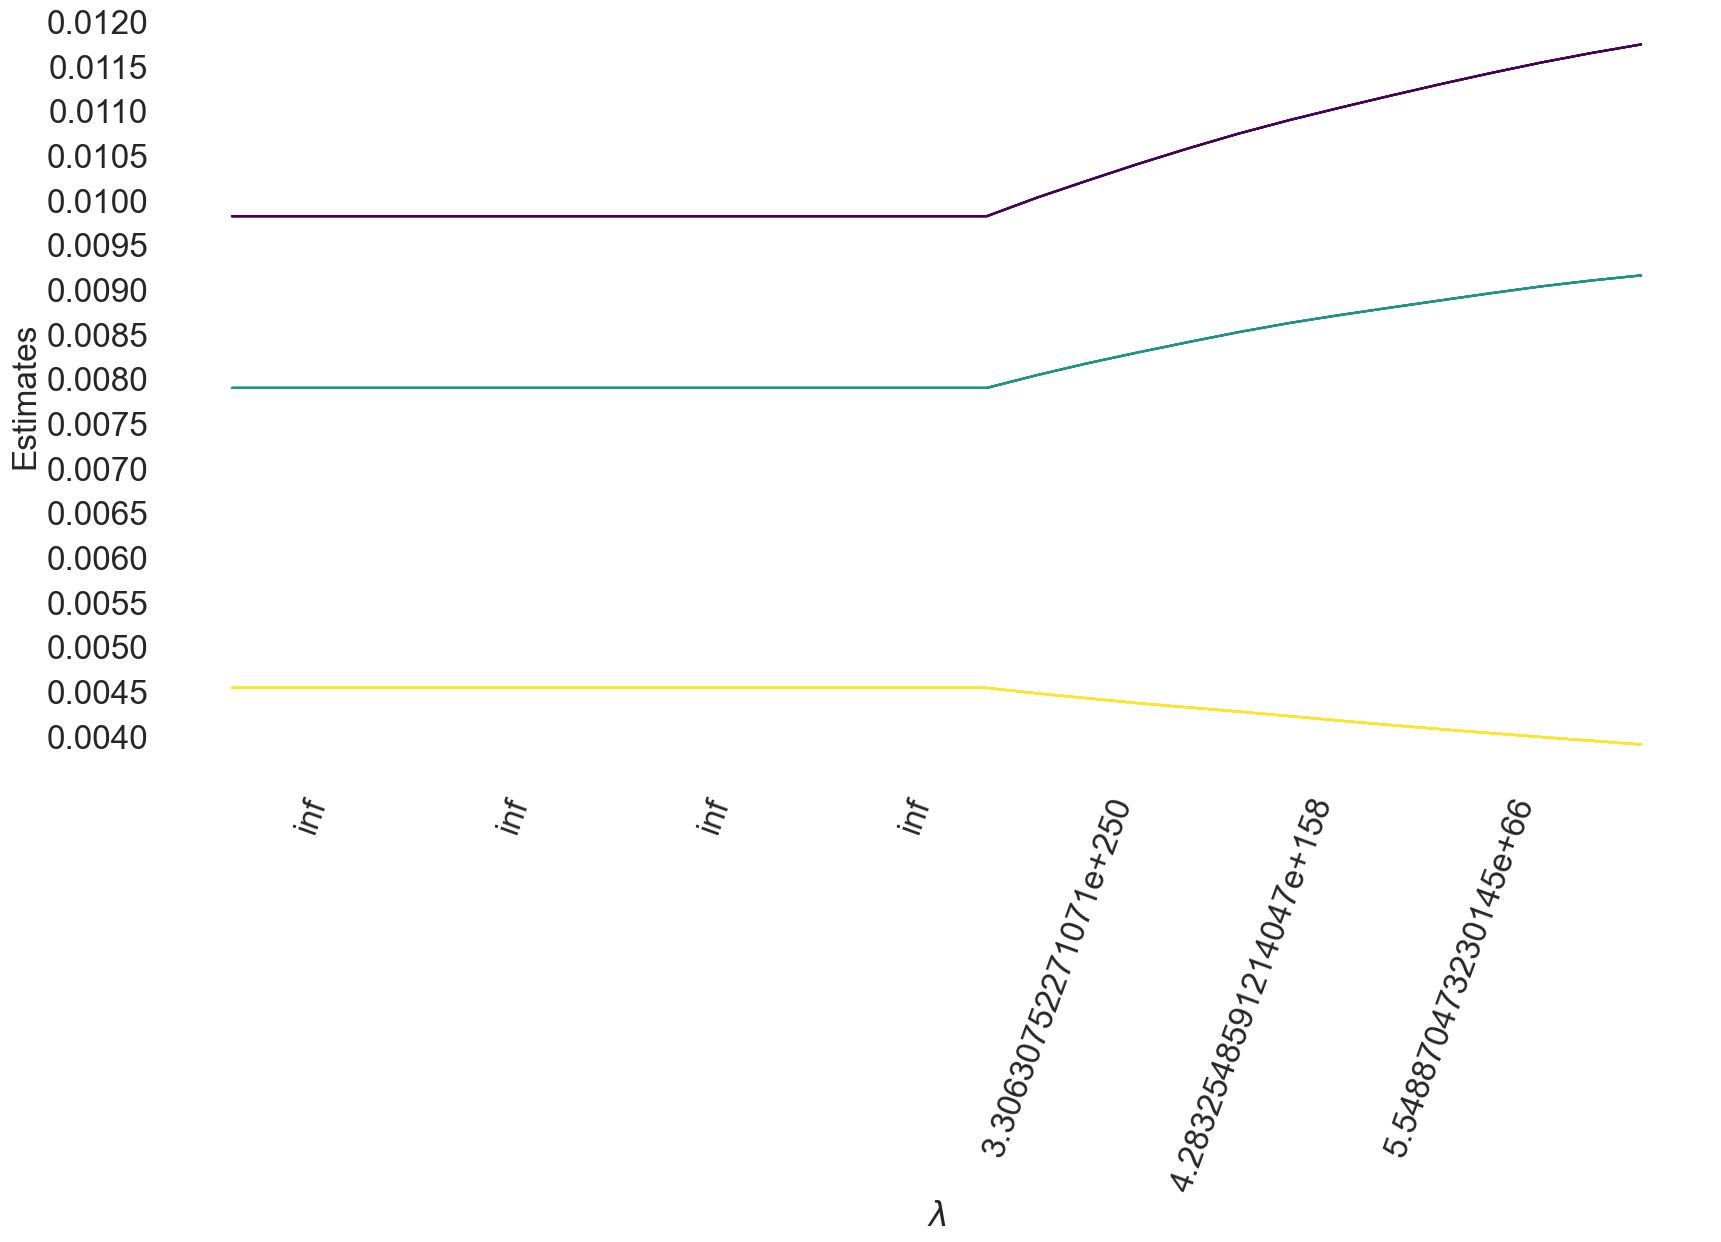

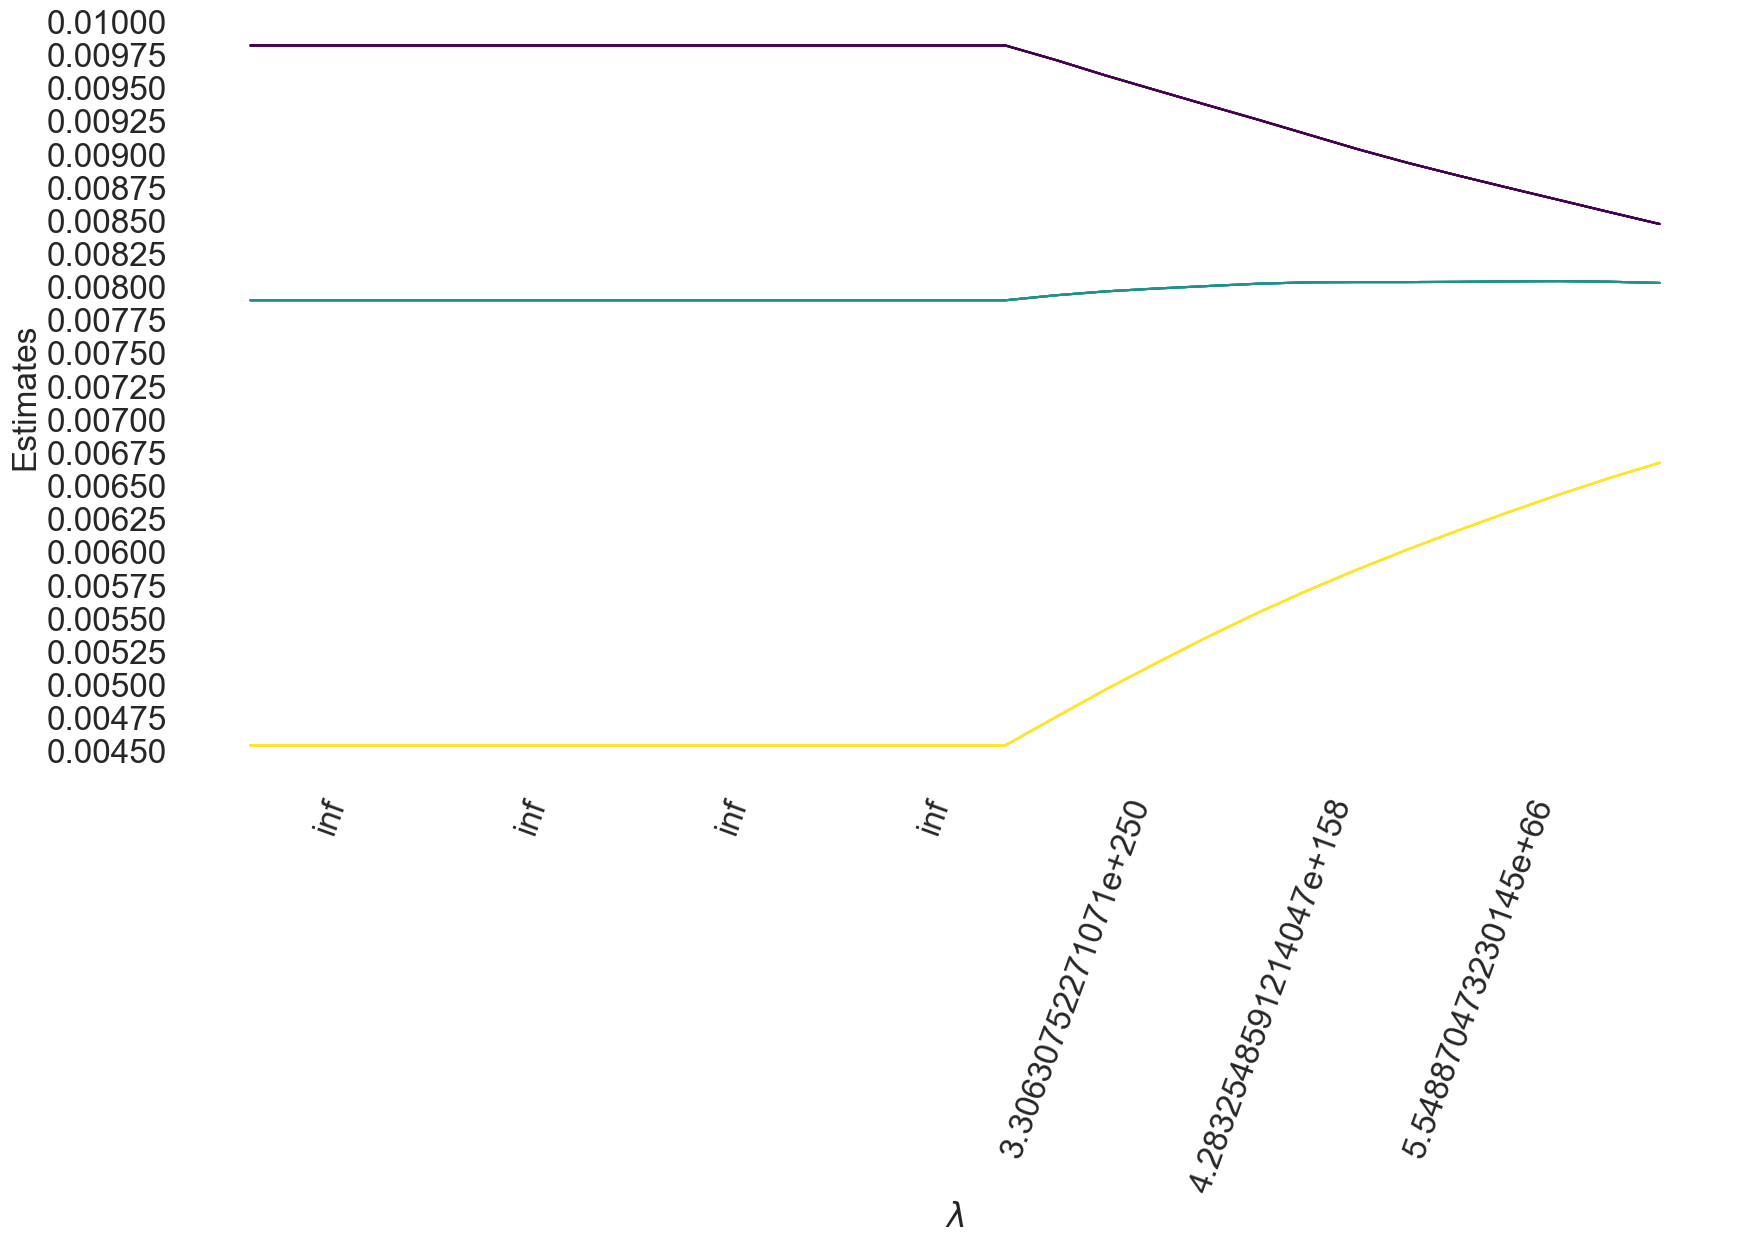

In [28]:
from p3ca import cluster_metrics, calculate_scores_nonpath
import time
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment as linear_assignment

centroids = []

Xhat_list = []
for p in range(len(penalty_list)):
    Xhat_list.append(np.hstack((np.array(U_list)[p,:,:],np.array(V_list)[p,:,:])))

labels, ari, nmi, acc = fit_spectral(Xhat_list[np.argmax(np.array(ari_list))], pd.factorize(true_clusters)[0], len(np.unique(true_clusters)))

print('Best IDX',p,'ACC:',acc,'ARI:',ari,'NMI:',nmi)
for p in range(len(penalty_list)):
    centroids.append(centroid_matrix(np.array(Xhat_list[p]),labels))

path_plot(np.asarray(centroids)[:,:,0:3], penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)
ax = plt.gca()
ax.set_facecolor('white')

path_plot(np.asarray(centroids)[:,pd.factorize(true_clusters)[0]==0,0:3], penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)
ax = plt.gca()
ax.set_facecolor('white')


path_plot(np.asarray(centroids)[:,pd.factorize(true_clusters)[0]==1,0:3], penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)
ax = plt.gca()
ax.set_facecolor('white')


path_plot(np.asarray(centroids)[:,pd.factorize(true_clusters)[0]==2,0:3], penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)
ax = plt.gca()
ax.set_facecolor('white')


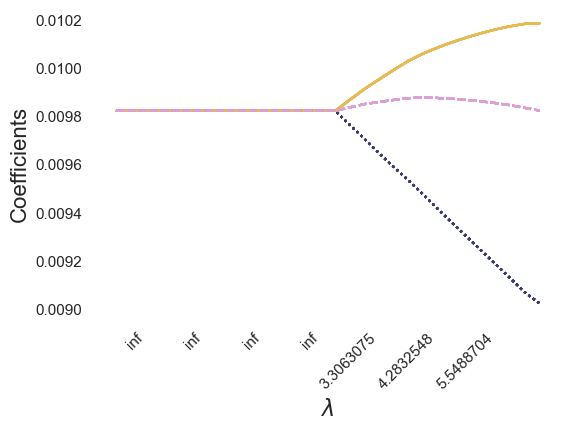

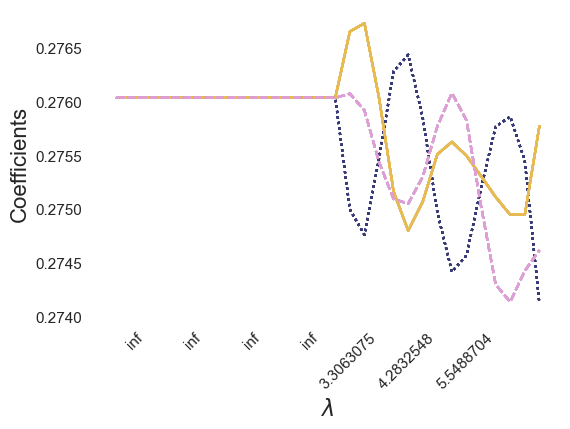

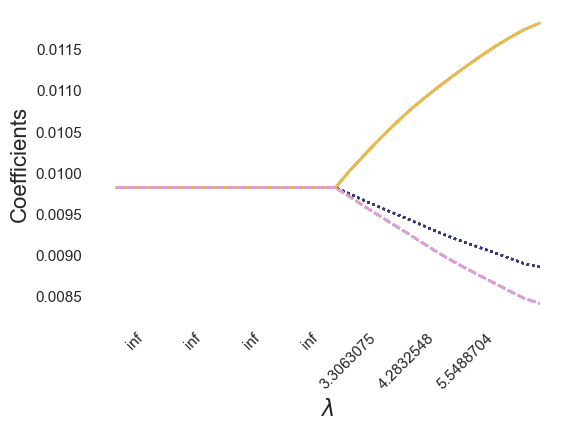

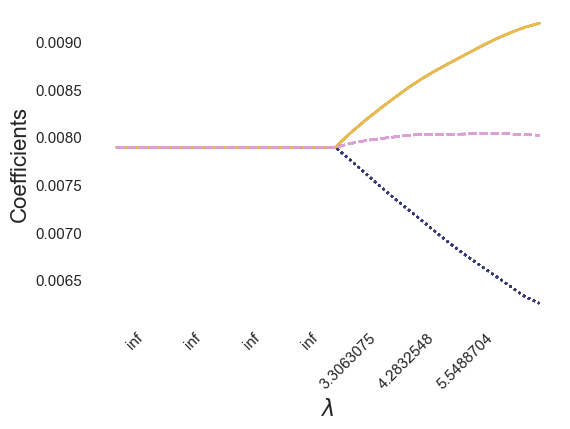

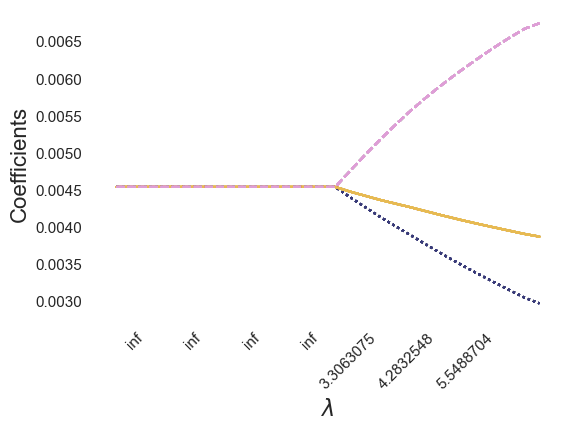

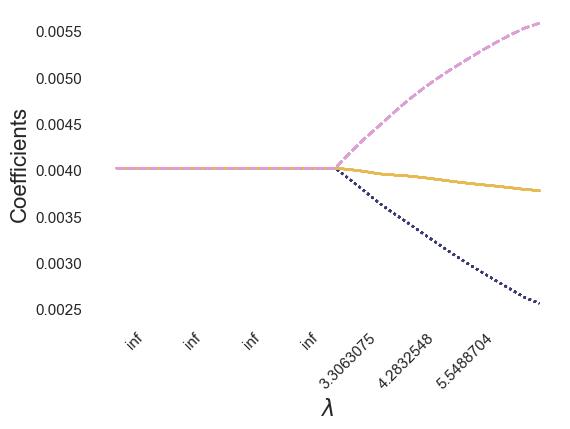

In [29]:


path_plot2(np.mean(np.asarray(centroids)[:,:,0:100],axis=2)[:,:,np.newaxis], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot2(np.asarray(centroids)[:,:,-1:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot2(np.asarray(centroids)[:,:,0:1], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot2(np.asarray(centroids)[:,:,1:2], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot2(np.asarray(centroids)[:,:,2:3], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)


path_plot2(np.asarray(centroids)[:,:,3:4], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)




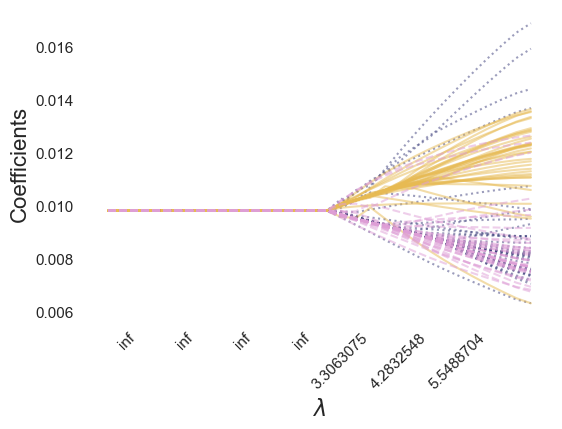

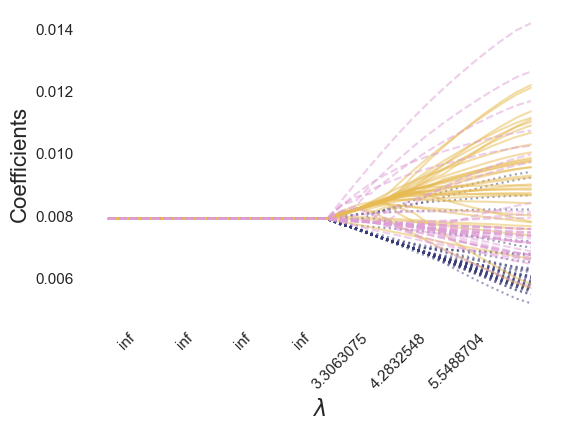

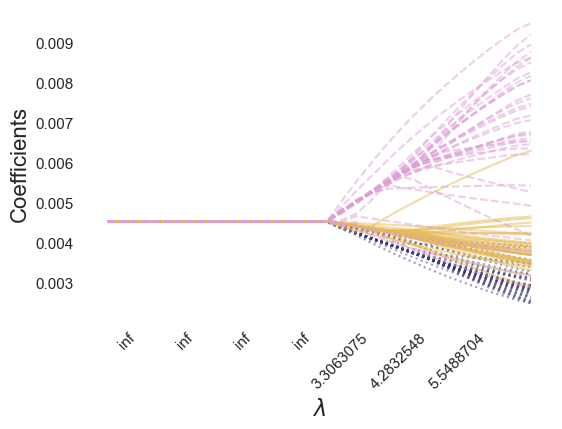

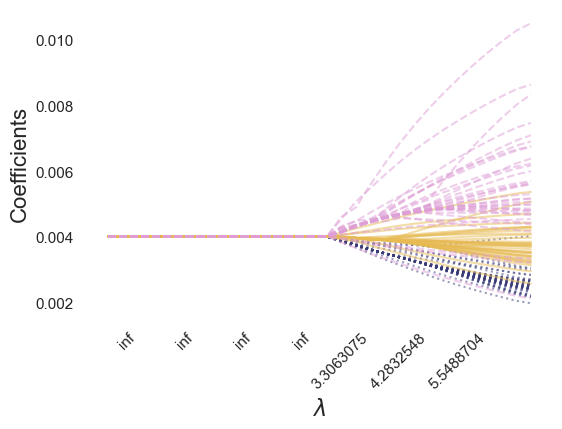

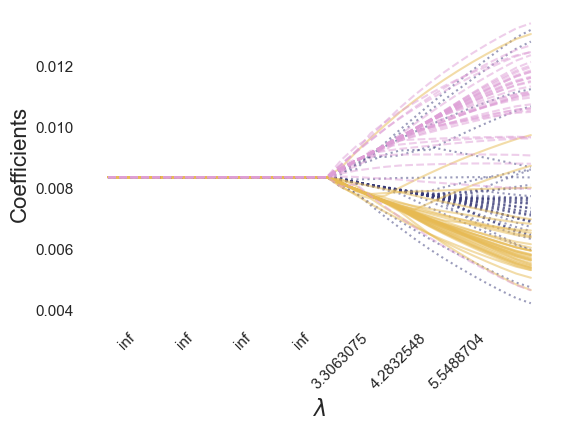

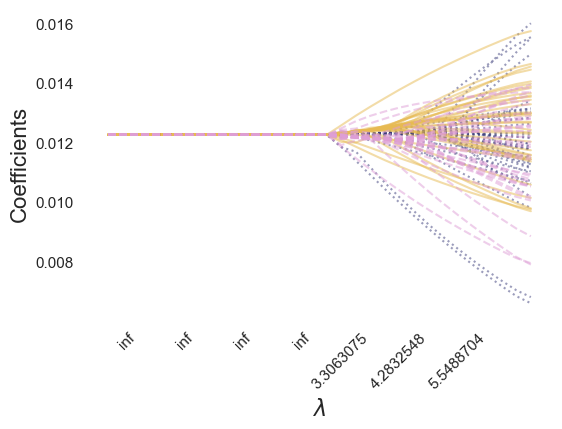

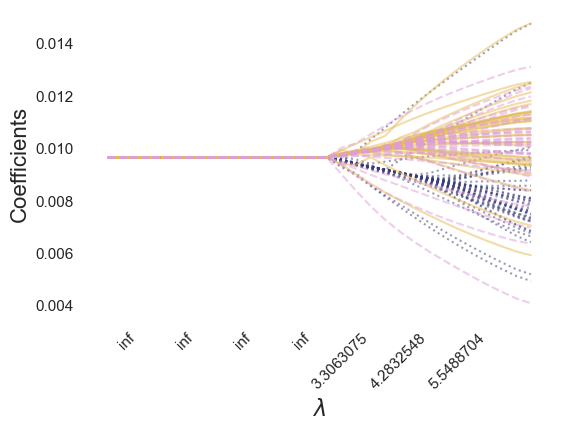

In [30]:
path_plot2(np.asarray(U_list)[:,:,0:1], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot2(np.asarray(U_list)[:,:,1:2], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot2(np.asarray(U_list)[:,:,2:3], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot2(np.asarray(U_list)[:,:,3:4], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)


path_plot2(np.asarray(U_list)[:,:,4:5], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot2(np.asarray(U_list)[:,:,5:6], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot2(np.asarray(U_list)[:,:,6:7], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

Best IDX 29 ACC: 1.0 ARI: 1.0 NMI: 1.0


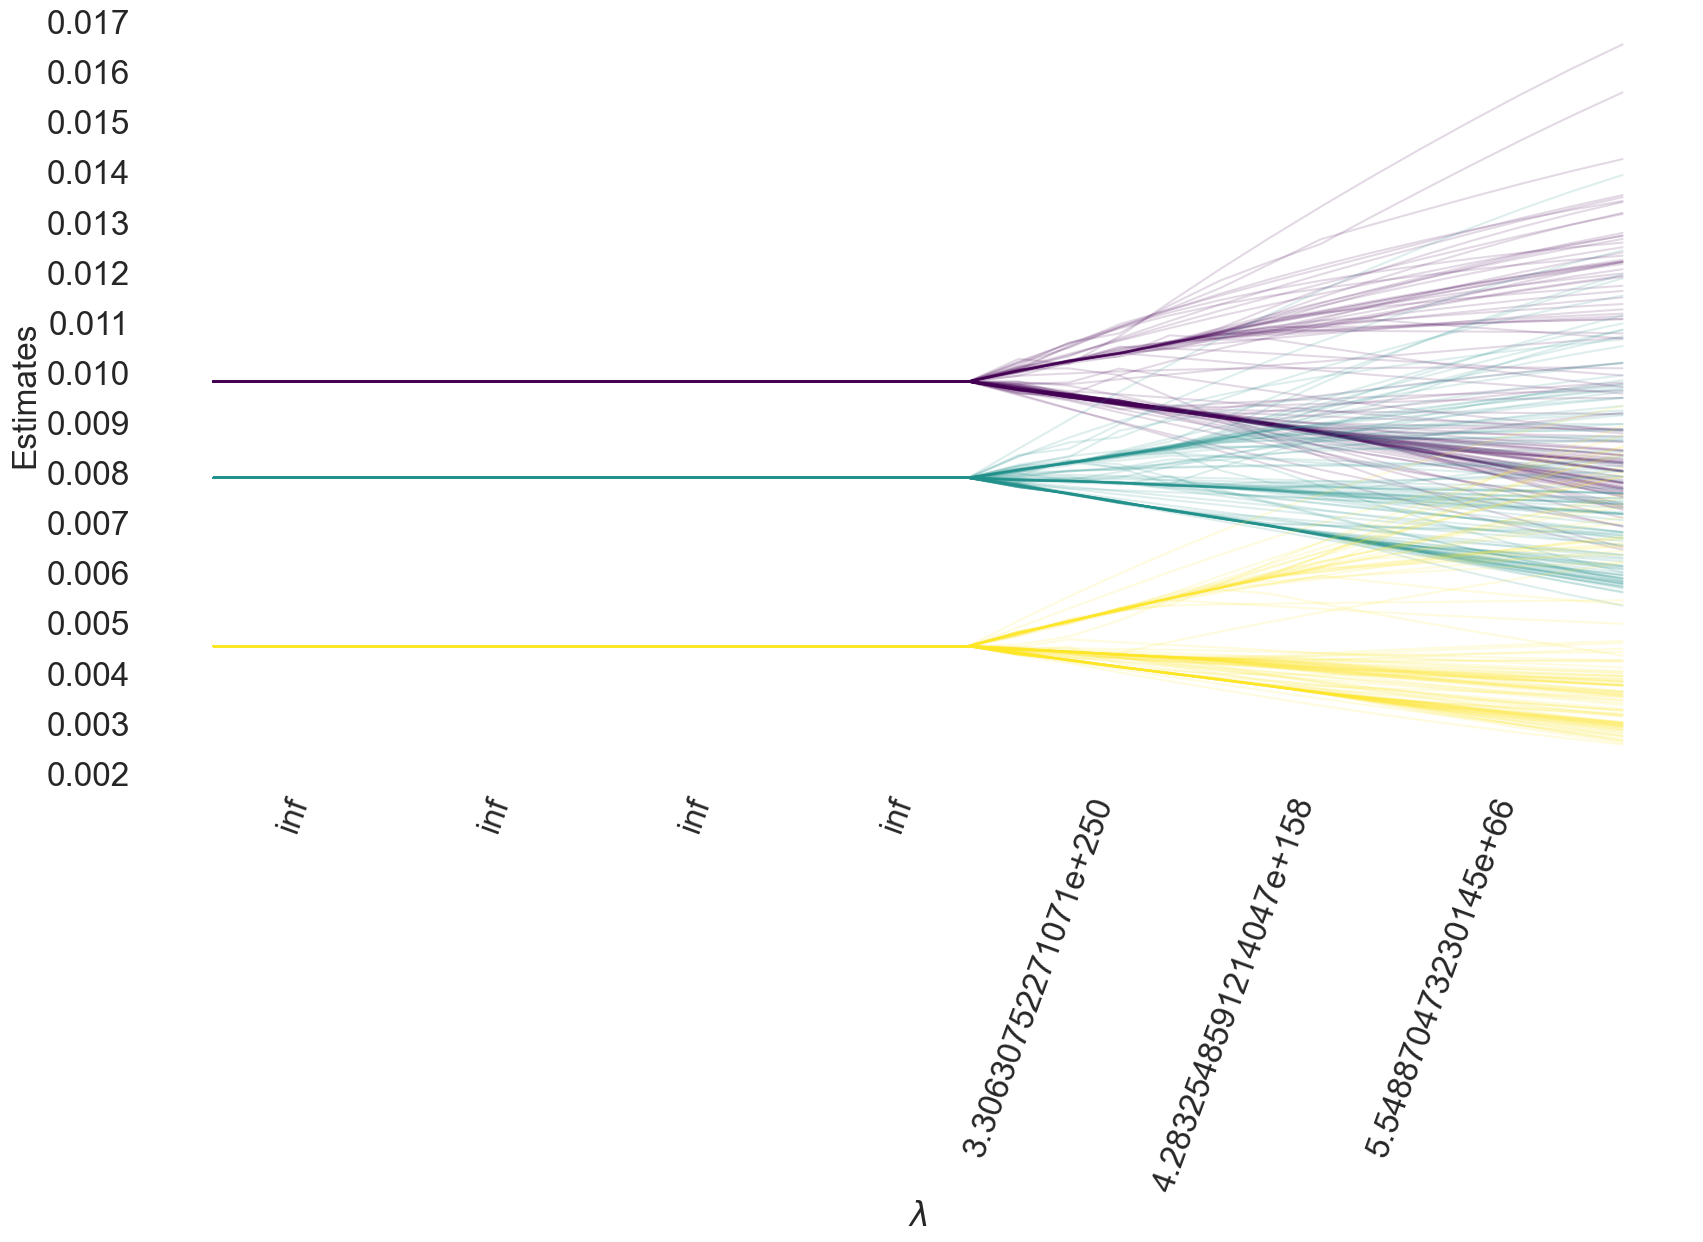

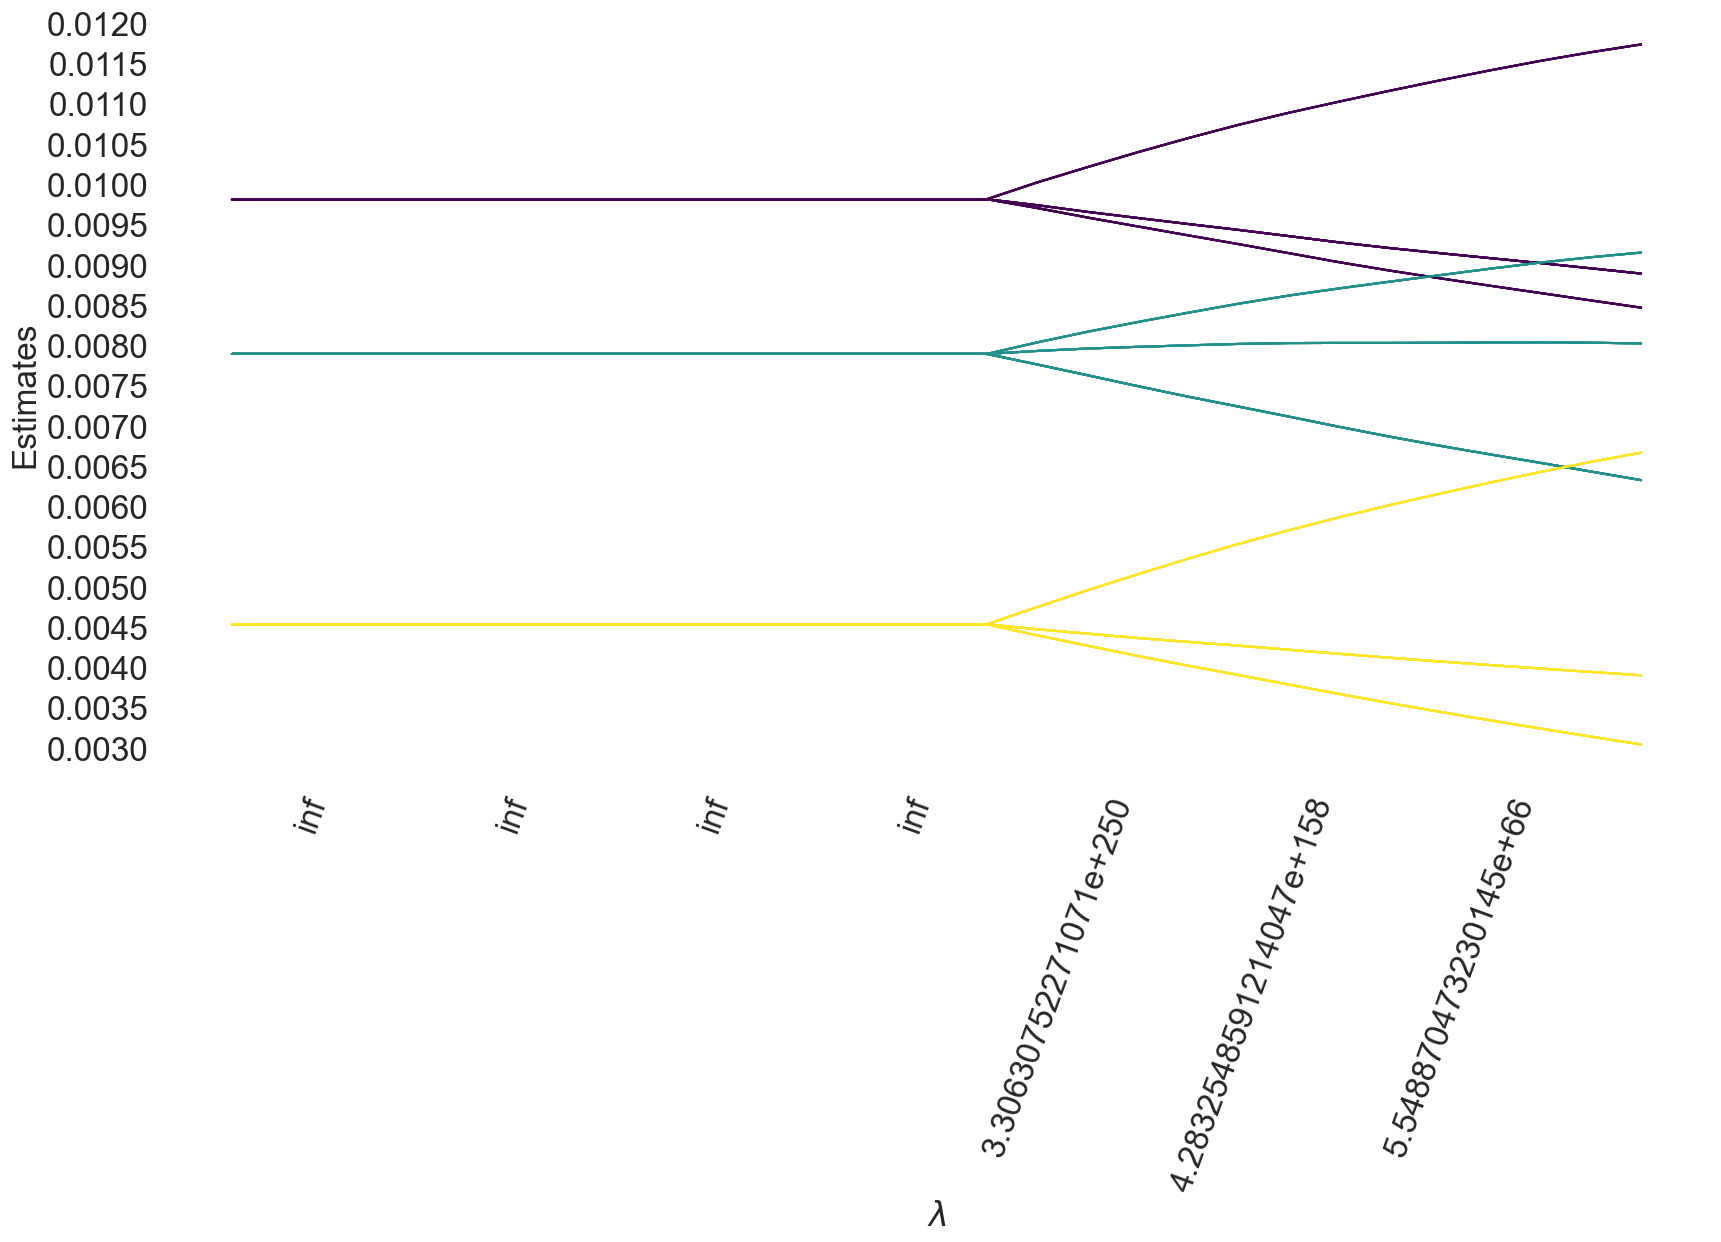

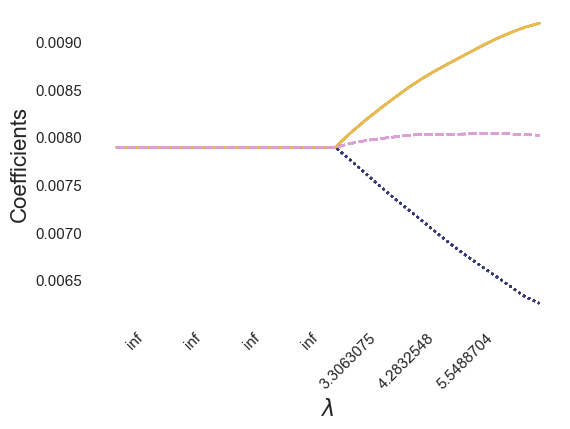

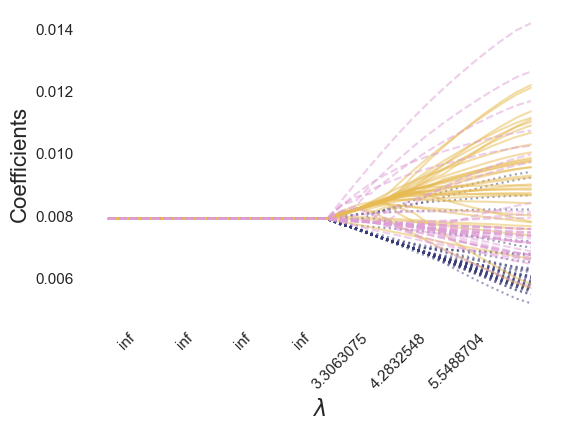

In [31]:
path_plot(np.asarray(U_list)[:,:,0:3], penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)
ax = plt.gca()
ax.set_facecolor('white')

centroids = []

Xhat_list = []
for p in range(len(penalty_list)):
    Xhat_list.append(np.hstack((np.array(U_list)[p,:,:],np.array(V_list)[p,:,:])))

labels, ari, nmi, acc = fit_spectral(Xhat_list[np.argmax(np.array(ari_list))], pd.factorize(true_clusters)[0], len(np.unique(true_clusters)))

print('Best IDX',p,'ACC:',acc,'ARI:',ari,'NMI:',nmi)
for p in range(len(penalty_list)):
    centroids.append(centroid_matrix(np.array(Xhat_list[p]),labels))

path_plot(np.asarray(centroids)[:,:,0:3], penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)
ax = plt.gca()
ax.set_facecolor('white')


path_plot2(np.asarray(centroids)[:,:,1:2], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)


path_plot2(np.asarray(U_list)[:,:,1:2], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=pd.factorize(true_clusters)[0], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)